This presentation has very wide content; resize your window to view it.
This line ensures content follows thenew window size, and inhibits line wrap.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#display(HTML("<style>.div.output_area pre { white-space: pre; }</style>")) # didn't work

# Extracting data from **email headers**  (in green)

### included in the body of an email:  
 
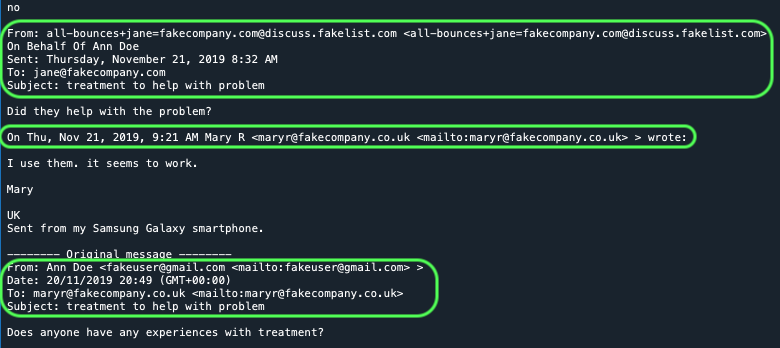

In [2]:
import qante                         # our package
import qante.loctuple as lt          # for docstrings [e.g. help(lt.seq_before)]
from qante.tagger import Tagger,lit  # Tagger class and lit() function
from qante.query import Query        # Function to query Tagged text

from jn_regex import DATE,TIME,EMAIL # local module w/regexps for date, time, email

## Example 1: Find subheaders matching:  __On__ ... {date} ...  __wrote__:  

In [3]:
# create tagged text object from file
f = open( 'email.txt', 'r')
text = f.read() 
tagged_email = Tagger(text)          # converts to lowercase by default

# tag locations of dates, times, and emails using their regexp's
tagged_email.tagRE('DATE', DATE)     # e.g. Thursday, November 21, 2019
tagged_email.tagRE('TIME', TIME)     # e.g. 8:31 AM, 9:21 AM, 20:49 (GMT+00:00)
tagged_email.tagRE('EMAIL', EMAIL)   # e.g. fakeuser@gmail.com

# tags is an ordered sequence of 5 tags:
tags = [lit('on'), 'DATE', 'TIME', 'EMAIL', lit('wrote:')]  # 0,1,2,3,4

# referenced by their positions in this predicate:
predicate = ('seq_before(0,1,2,3,4)'  # tags in order 
    ' and dist(0,4)<100')             # 'on' within 100 chars of 'wrote:

### Query the tagged text:

Executing the query returns 3-tuples from *tagged_email* using *predicate* referencing *tags*.

Show Query's docstring, which shows valid predicate syntax (below):

In [4]:
Query?

Here's the line we're querying for:
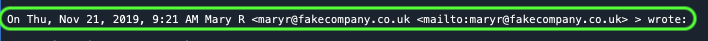

In [5]:
query = Query(tags, predicate, tagged_email, [1,2,3])  # (date, time, email)

In [6]:
triplets = query.execute()            # returns list of 3-tuples
tagged_email.display_tuples(triplets) # prints two tuples

('thu, nov 21, 2019', '9:21 am ', 'maryr@fakecompany.co.uk')
('thu, nov 21, 2019', '9:21 am ', 'maryr@fakecompany.co.uk')


### We now have two 3-tuples: one for each occurrence of email maryr@fakecompany.co.uk

#### To remove the extra tuple,  simply constrain query to select only one of the emails: the one closer to 'wrote:'

In [7]:
pred = 'seq_before(0,1,2,3,4) and dist(0,4)<100 and dist(3,4) < 10'
qry = Query(tags, pred, tagged_email, [1,2,3])
triples = qry.execute()
tagged_email.display_tuples(triples)

('thu, nov 21, 2019', '9:21 am ', 'maryr@fakecompany.co.uk')


## Example 2: Extract emails, dates, and times, from email headers

from same email as above
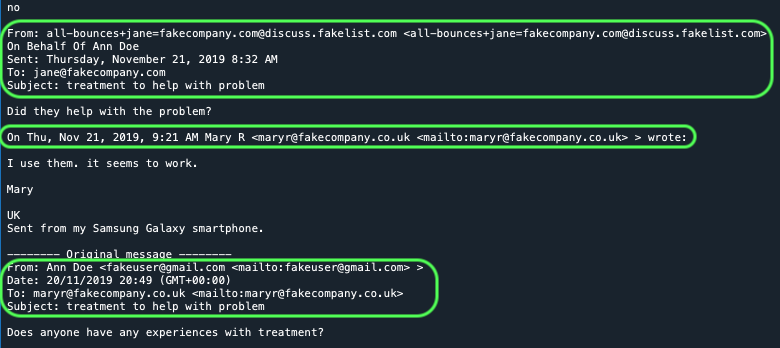

In [8]:
if len(tagged_email.get_locs('SENTDATETIME')) == 0:  # allow re-exection of cell w/o error
  tagged_email.tagRE('SENTDATETIME', '(sent:)|(date:)')
    
tags = [lit('from:'),  'EMAIL',  lit('>'),       # 0,1,2
    'SENTDATETIME', 'DATE', 'TIME',              # 3,4,5
    lit('to:'),  'EMAIL',                        # 6,7
    lit('subject:')                              # 8
]

pred = ('seq_before_meets(0,1,2,3,4,5,6,7,8)'     # tags in order (possibly adjacent)
    ' and dist(0,8) < 350 and dist(1,2) < 5'      # 'from:' within 350 chars of 'subject:'
    ' and dist(6,7) < 5')                         # 'to:' within 5 chars of EMAIL
qry = Query(tags, pred, tagged_email, [1,4,5,7])  # (from_email, date, time, to_email)
quadruplets = qry.execute()
tagged_email.display_tuples(quadruplets)

('all-bounces+jane=fakecompany.com@discuss.fakelist.com', 'thursday, november 21, 2019', '8:32 am', 'jane@fakecompany.com')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')


### duplicate rows appear above because "to:" appears twice, in 'to:' and 'mailto:'

#### To skip the 'to:' in 'mailto:', use a user-defined-predicate (UDP) that returns False if text preceeding location is 'mail'

In [9]:
pred = ('seq_before_meets(0,1,2,3,4,5,6,7,8)'
    ' and dist(0,8) < 350 and dist(1,2) < 5 and dist(6,7) < 5'
    ' and not_preceeded_by_mail(6)') # this UDP has one Loc parm: index 6 ('to:')
qry = Query(tags, pred, tagged_email, [1,4,5,7])
qry.UDP('not_preceeded_by_mail',  # UDPs expect a tuple of Loc ations
    lambda locs: not (
        tagged_email.text[locs[0].start()-4:].startswith('mail'))
)
quads = qry.execute()
tagged_email.display_tuples(quads)


('all-bounces+jane=fakecompany.com@discuss.fakelist.com', 'thursday, november 21, 2019', '8:32 am', 'jane@fakecompany.com')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')


# Example 3: Extracting Tables from text layouts

## We want to extract a table (shown in green) from electric bills:

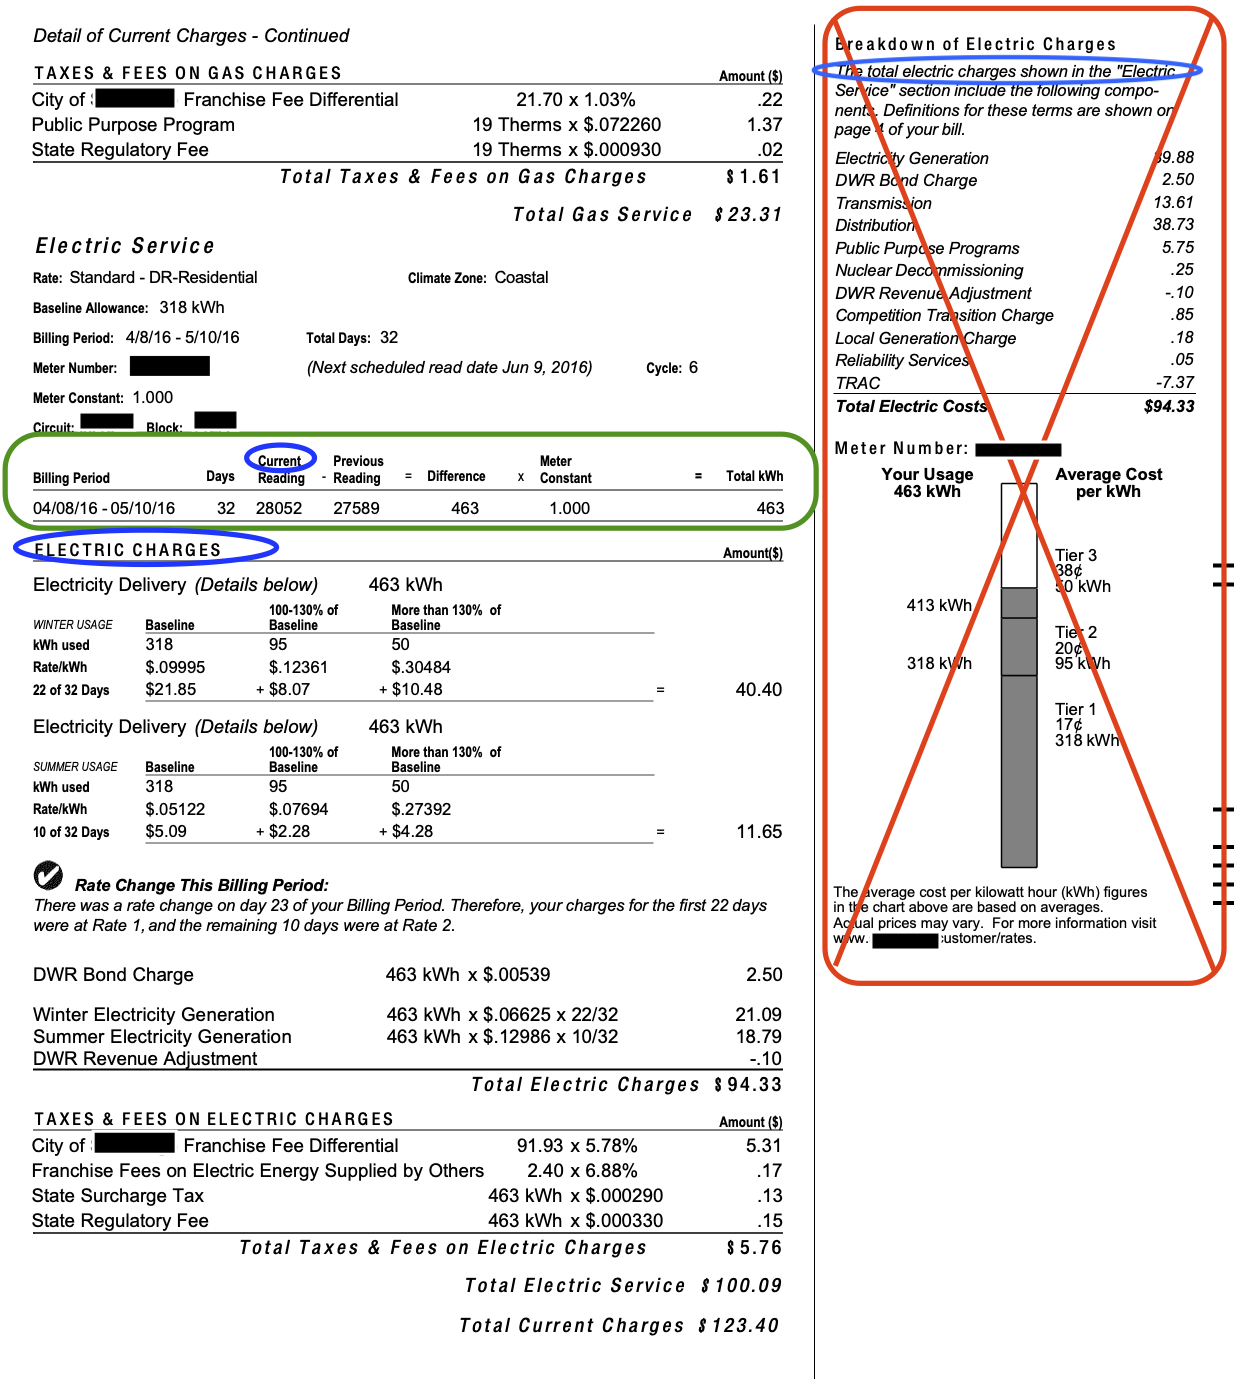

###  Read text from one page of the bill (from  `pdf2text -layout`)

In [10]:
import qante.utilities as ut
f = open('bill.txt')
text = f.read() 

In [11]:
print(text[0:2000])  # very wide output (resize window to see it)

Detail of Current Charges - Continued                                                                                  Breakdown of Electric Charges
TAXES & FEES ON GAS CHARGES                                                                               Amount ($)   The total electric charges shown in the "Electric
                                                                                                                       Service" section include the following compo-
City of xxxxxxxxx Franchise Fee Differential      21.70 x 1.03%                                               .22
                                                                                                                       nents. Definitions for these terms are shown on
Public Purpose Program                       19 Therms x $.072260                                            1.37      page 4 of your bill.
State Regulatory Fee                         19 Therms x $.000930                               

## Remove column on right (in red) 

1. find locations of all text in same column as '*the total...electric*' [shown in blue] (`get_column`)
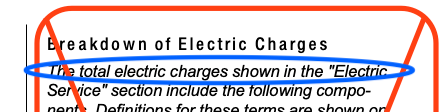
2. tag them as NOISE (`tag_list`)
3. return text with tagged text deleted (`replace_tag`)

* See doctrings of each function for details: shift-tab(on *name*) or help(*name*)


In [12]:
bill = Tagger(text)
str_in_column = 'the total electric charges shown in the "electric'
bill.tag_list('NOISE', ut.get_column(bill.text, str_in_column))
clean_elec_txt = bill.replace_tag('NOISE', '')
print(clean_elec_txt[0:2000])

detail of current charges - continued                                                                                  
taxes & fees on gas charges                                                                               amount ($)   
                                                                                                                       
city of xxxxxxxxx franchise fee differential      21.70 x 1.03%                                               .22
                                                                                                                       
public purpose program                       19 therms x $.072260                                            1.37      
state regulatory fee                         19 therms x $.000930                                             .02                                
                            total taxes & fees on gas charges                                              $1.61                            

## Import modules

In [13]:
from qante.loctuple import open_right_span
from qante.loclist import shortest
from qante.table import get_table

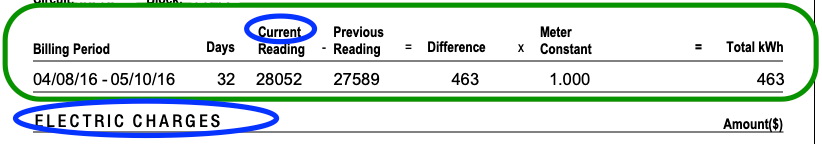

## Fetch content of desired table (in green)
1. tag `LINE`s (`tagRE`)
2. get location of line containing "current"(`subinterval`) `before` "electric charges"
3. return the locations of that line and  "electric charges" (`pairs`)
4. select the text from start of line containing "current" upto "electric charges" (`open_right_span`)
5. choose the shortest one (there may have been others; e.g. from multiple pages)

In [14]:
elec = Tagger(clean_elec_txt)
elec.tagRE('LINE', ut.LINE)

tags = ['LINE', lit('current'), lit('electric charges')]

qry = Query(tags, 'subinterval(1, 0) and before(0, 2)', elec, [0,2])
pairs = qry.execute()

locs = shortest(list(map(open_right_span, pairs)))
table_txt = elec.get_text_loc(locs[0])
print(table_txt)

                                   current       previous                           meter
billing period              days   reading     - reading      =   difference    x   constant          =    total kwh                           
                                                                                                                                                    
04/08/16 - 05/10/16          32    28052         27589                463             1.000                    463




## Extract fields from table  text (`get_table`)

In [15]:
mytable = get_table(table_txt,2)   # top two lines are the header
print(mytable)

[{'billing period': '04/08/16 - 05/10/16', 'days': '32', 'current reading': '28052', 'previous - reading': '27589', 'difference': '463', 'meter constant': '1.000', 'total kwh': '463'}]
